# ALS of Heidelberg terrain demo

Notebook creator: Hannah Weiser, 2026

This demo uses a digital terrain model (DTM) of Heidelberg, Germany, which will be scanned by airborne laser scanning (ALS).

In [1]:
import helios
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Creating the virtual scene

In [2]:
# load geotiff
dtm = helios.ScenePart.from_tiff("../data/sceneparts/tiff/dem_hd.tif")
# scene
scene = helios.StaticScene(scene_parts=[dtm])

## Platform and Scanner

In [3]:
scanner = helios.scanner_from_name("leica_als50_ii")
platform = helios.platform_from_name("sr22")

## Scanner and platform settings

In [4]:
# these scanner settings will be shared between all legs
scanner_settings = helios.ScannerSettings(pulse_frequency=60_000 * helios.units.Hz,
                                          scan_frequency=50 * helios.units.Hz,
                                          scan_angle=60 * helios.units.deg,
                                          trajectory_time_interval=0.05 * helios.units.s
                                         )    
#Q: How to change detector settings (like maximum range) in a survey???

z = 1500.0  # m
speed = 150  # m/s

## Survey Route

In [5]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)

In [6]:
waypoints = [
    [474500, 5474500],
    [490000, 5474500],
    [474500, 5473500],
    [490000, 5473500]
]
for x, y in waypoints:
    survey.add_leg(x=x, y=y, z=z, speed_m_s=speed, scanner_settings=scanner_settings)

## Executing the survey

In [7]:
points, trajectories = survey.run(verbosity=helios.LogVerbosity.VERBOSE, format=helios.OutputFormat.NPY)

## Visualizing the results

Now we can display a couple of 2D plots of the simulated point cloud. We create two plots - one from above and one from the side - showing the point cloud colored by flight strip and the trajectory.

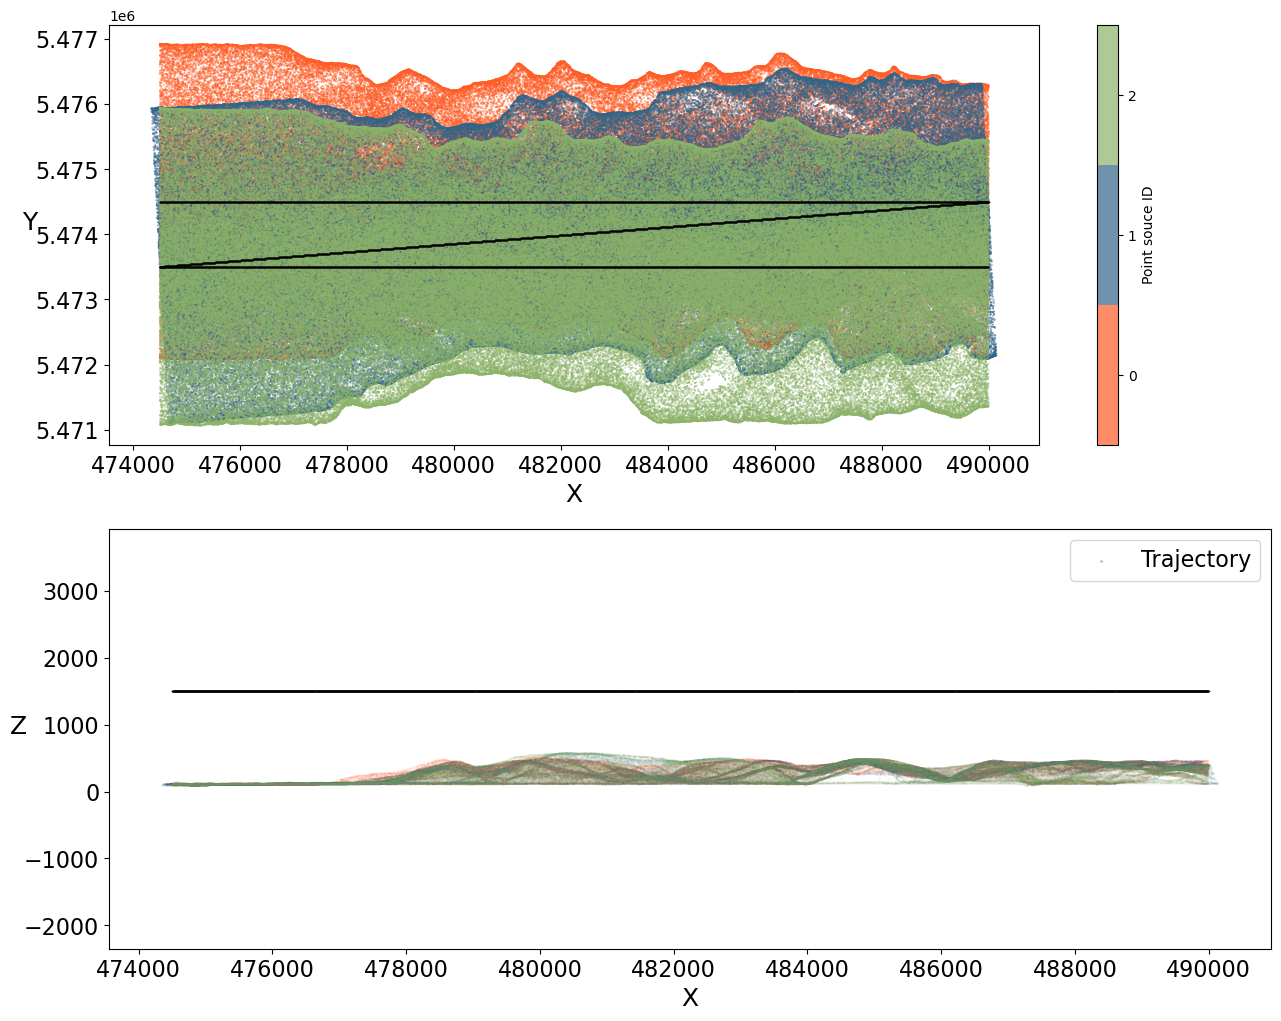

In [8]:
# two subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 12))
pos = points["position"]
traj = trajectories["position"]

N = 3
colors = ["#FE5D26", "#33658A", "#8CB369"]
rgba_colors = [mcolors.to_rgba(c) for c in colors]
cmap = mcolors.ListedColormap(rgba_colors, name="custom")  # discrete colormap with 3 colors

# view from above, colored by strip, including trajectory - for faster display, show only every 25th measurement
sc = ax1.scatter(
    pos[::25, 0], pos[::25, 1], s=0.1, alpha=0.7, c=points["point_source_id"][::25], cmap=cmap,
    vmin=-0.5, vmax=N - 0.5
)
ax1.scatter(traj[:, 0], traj[:, 1], s=0.1, label="Trajectory", color="black")
ax1.tick_params(labelsize=16)
ax1.set_xlabel("X", fontsize=18)
ax1.set_ylabel("Y", fontsize=18, rotation=0)

plt.colorbar(sc, ticks=[0, 1, 2], label="Point souce ID")

# use only every 50th measurement for better display
ax2.scatter(
    pos[::50, 0], pos[::50, 2], alpha=0.05, s=0.1, c=points["point_source_id"][::50], cmap=cmap,
    vmin=-0.5, vmax=N - 0.5
)  # select X and Z coordinates
ax2.scatter(traj[:, 0], traj[:, 2], s=0.05, label="Trajectory", color="black")
ax2.tick_params(labelsize=16)
ax2.set_xlabel("X", fontsize=18)
ax2.set_ylabel("Z", fontsize=18, rotation=0)
ax2.legend(fontsize=16)

plt.axis("equal")
plt.show()

Let's create another plot from above which is colored by altitude.

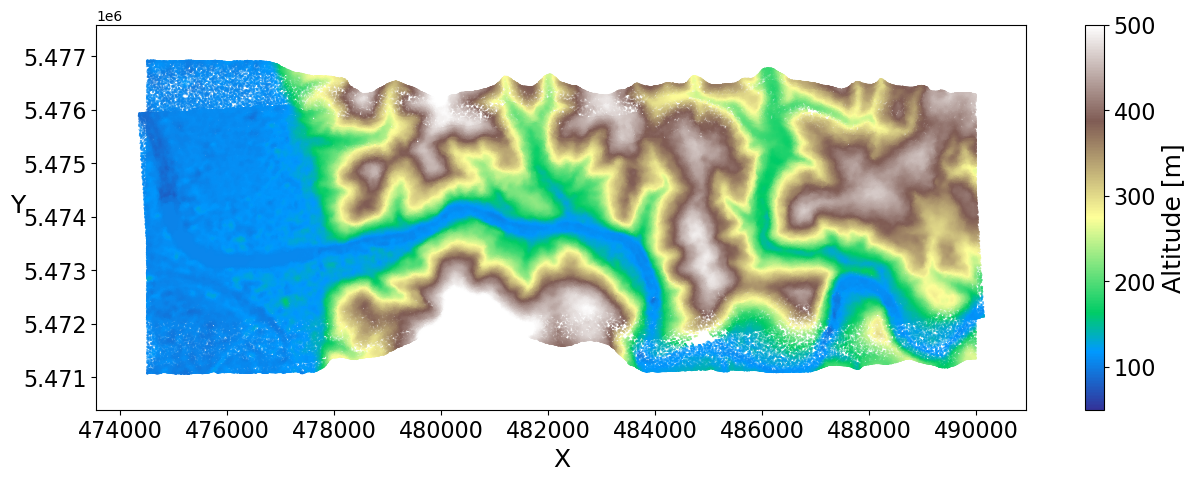

In [9]:
# view from above - colored by altitude
fig, ax = plt.subplots(figsize=(15, 5))

# select X and y coordinates
plot1 = ax.scatter(
    pos[::20, 0],
    pos[::20, 1],
    s=0.1,
    c=pos[::20, 2],
    cmap="terrain",
    vmin=50,
    vmax=500,
)

plt.axis("equal")
ax.tick_params(labelsize=16)
plt.xlabel("X", fontsize=18)
plt.ylabel("Y", fontsize=18, rotation=0)

cbar = plt.colorbar(plot1)
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Altitude [m]", fontsize=18)
plt.show()

Finally, plot only a section of the point cloud to get a profile of the Neckar valley in Heidelberg.

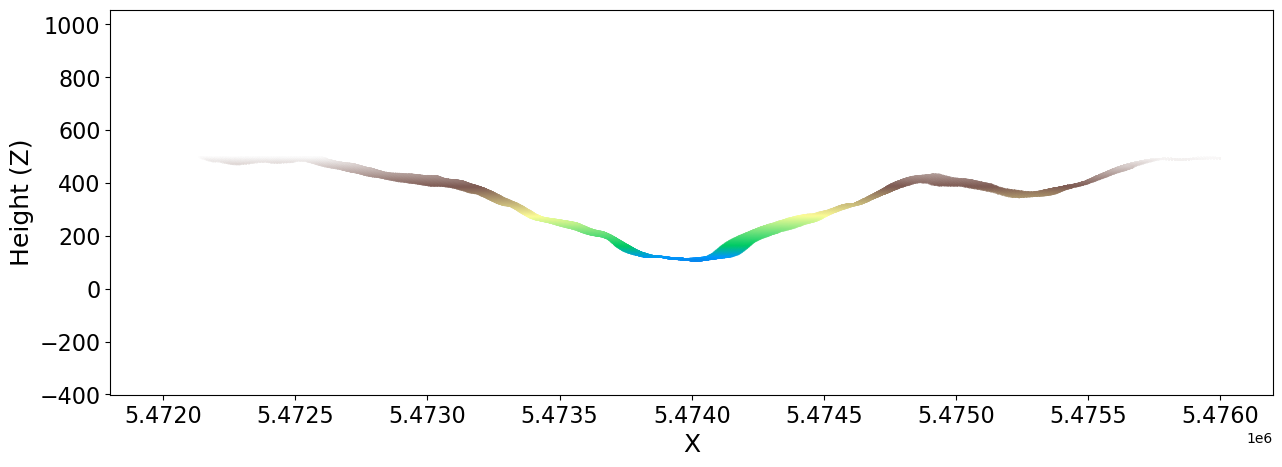

In [10]:
# Section in direction of Y
xmin, ymin, xmax, ymax = [480000, 5472000, 480100, 5476000]

section = pos[
    (pos[:, 0] > xmin)
    & (pos[:, 0] < xmax)
    & (pos[:, 1] > ymin)
    & (pos[:, 1] < ymax)
]

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()

ax.scatter(
    section[:, 1],
    section[:, 2],
    c=section[:, 2],
    cmap="terrain",
    s=0.01,
    vmin=50,
    vmax=500,
)
ax.tick_params(labelsize=16)

plt.xlabel("X", fontsize=18)
plt.ylabel("Height (Z)", fontsize=18, rotation=90)
plt.axis("equal")
plt.show()